In [1]:
import cmocean as cmo
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal
import warnings
warnings.filterwarnings('ignore')
from xmitgcm import open_mdsdataset
import seaborn as sns

In [2]:
outdir = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/01_SVB_febTS_output/'
outdir2 = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL/01_noSVB_febTS/'

levels = [1,   2,  3,  4,  5,  6,  7,  8,  9, 10, 
          11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25,
          26, 27, 28, 29, 30, 31,
          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,              
          58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 
          74, 79, 84, 89, 94, 99,]
ds = open_mdsdataset(outdir, prefix=['eta','dynVars'], levels=levels)
ds2 = open_mdsdataset(outdir2, prefix=['eta','dynVars'], levels=levels)

In [3]:
depth_nob = ds2.Depth[:]
LAT = ds2['YC'][:]
LON = ds2['XC'][:]-360
lat = ds2.YC[:,0].data
lon = ds2.XC[0,:].data-360

Z = ds2['Z'][:]
Zl = ds2['Zl'][:]

# centers mask
hFacC = ds2['hFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
dep_masked = np.ma.masked_values(depth_nob,0)
mask_dep = np.ma.getmask(dep_masked)

times1 = np.arange(720)*600
times2 = np.arange(720)*1200+(720*600)
times = np.concatenate((times1,times2))

# centers mask bathy with bay
depth_bay = ds.Depth[:]
hFacCSVB = ds['hFacC'][:]
hfacSVB = np.ma.masked_values(hFacCSVB, 0)
maskSVB = np.ma.getmask(hfacSVB)

In [4]:
def get_snapshot_at_level(ds,tt,zz,fld):
    W = ds[fld][tt,zz,:,:]
    return(W)

def get_snapshot_eta(ds,tt):
    Eta = ds['ETAN'][tt,:,:]
    return(Eta)

def plot_field_w(ax,tt,lon,lat,fld,time,mask,zind,title,
                 cmap=cmo.cm.balance,vmin=-0.3, vmax=0.3, cb=1):
    ax.set_facecolor('tan')
    cmap.set_over("lavender")
    cmap.set_under("lavender")
    levels = np.linspace(vmin,vmax,30)
    pc = ax.pcolormesh(lon,lat, 
                       np.ma.masked_array(fld,mask=mask[zind,:,:]),
                       cmap=cmap, norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False))
    ax.contour(lon,lat,depth_nob, levels=[0], color='k')
    ax.contour(lon,lat,depth_bay, levels=[0], color='k')
    ax.contour(lon,lat,depth_bay, levels=[500], color='0.5', alpha=0.5)
     
    if cb==1:
        cbar_ax = fig.add_axes([0.115, 0.86, 0.25, 0.04])
        cb = fig.colorbar(pc, 
                          cax=cbar_ax,
                          orientation='horizontal', 
                          format='%1.0f', extend='both', label='SSH ($10^{-4}$ m)', 
                          ticks=[-2,-1,0,1,2])
        cb.ax.xaxis.set_label_position("top")
    elif cb==4:
        cbar_ax = fig.add_axes([0.385, 0.86, 0.25, 0.04])
        cb = fig.colorbar(pc, 
                          cax=cbar_ax,
                          orientation='horizontal', 
                          format='%1.1f',extend='both', label='$v$ (mm$~$s$^{-1}$)', 
                          ticks=[-1.4,-0.7,0,0.7,1.4])
        cb.ax.xaxis.set_label_position("top")
    else:
         cbar_ax = fig.add_axes([0.655, 0.86, 0.25, 0.04])
         cb = fig.colorbar(pc, 
                           cax=cbar_ax,
                           orientation='horizontal', 
                           format='%1.0f',extend='both', label='$w$ ($10^{-6}$ m$~$s$^{-1}$)',
                           ticks=[-8,-6,-4,-2,0,2,4,6,8])
         cb.ax.xaxis.set_label_position("top")
    
    ax.text(0.45,0.9, title, transform=ax.transAxes)
    ax.set_aspect(1)
    return(ax)
    
def make_fig(tt):
    print((tt*600)/3600)
    Eta_bay = get_snapshot_eta(ds, tt)
    Eta_nb = get_snapshot_eta(ds2, tt)
    Wbay = get_snapshot_at_level(ds, tt, zz2, 'WVEL')
    Wnb = get_snapshot_at_level(ds2, tt, zz2, 'WVEL')
    Vbay = get_snapshot_at_level(ds, tt, zz, 'VVEL')
    Vnb = get_snapshot_at_level(ds2, tt, zz, 'VVEL')
   
     
    axx = plot_field_w(ax1,tt,lon,lat,(Eta_bay-Eta_nb)*10000,times,
                      mask,zz,
                      'surface',cmap=cmo.cm.curl, vmin=-2, vmax=2, cb=1)
    axx4 = plot_field_w(ax4,tt,lon,lat,(Vbay-Vnb)*1000,times,
                        mask,zz,
                        'surface'%(times[tt]/3600) ,
                         cmap=cmo.cm.balance, vmin=-1.4, vmax=1.4, cb=4)
    axx2 = plot_field_w(ax2,tt,lon,lat,(Wbay-Wnb)*1E6,times,
                        mask,zz2,
                        r'%1.0f m depth' %(-Zl[zz2]),
                        cmap=cmo.cm.balance, vmin=-8, vmax=8, cb=2)
   
    ax1.set_ylabel('lat')
    ax1.set_xlabel('lon')
    ax2.set_xlabel('lon')
    ax4.set_xlabel('lon')
    ax1.set_xlim(-121.5,-114)
    ax2.set_xlim(-121.5,-114)
    ax4.set_xlim(-121.5,-114)

    ax1.text(0.05,0.05, '(a)', transform=ax1.transAxes, fontweight='bold')
    ax4.text(0.05,0.05, '(b)', transform=ax4.transAxes, fontweight='bold')
    ax2.text(0.05,0.05, '(c)', transform=ax2.transAxes, fontweight='bold')

83.33333333333333


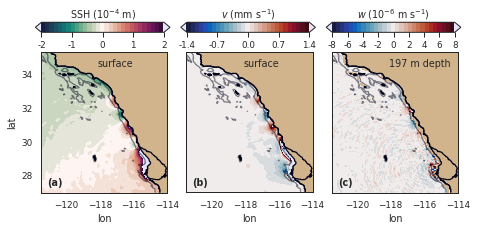

In [5]:
sns.set_context('paper')
sns.set_style('white')

zz = 0
zz2 = 37
tt = 500

fig = plt.figure(figsize=(7.48,3.5))
gs = GridSpec(1,3, wspace=0.15, hspace=0.1)
ax1 = fig.add_subplot(gs[0])
ax4 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2])
for ax in [ax2,ax4]:
    ax.set_yticks([])
    
make_fig(tt)  

plt.savefig('figure6.png', dpi=500, bbox_inches='tight')

snapshot of ssh, u , v at 83.3 hr

In [6]:
83.3/24

3.470833333333333

100.0


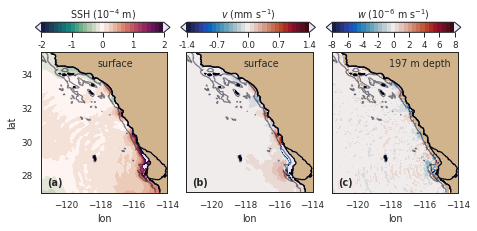

In [7]:
sns.set_context('paper')
sns.set_style('white')

zz = 0
zz2 = 37
tt = 600

fig = plt.figure(figsize=(7.48,3.5))
gs = GridSpec(1,3, wspace=0.15, hspace=0.1)
ax1 = fig.add_subplot(gs[0])
ax4 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2])
for ax in [ax2,ax4]:
    ax.set_yticks([])
    
make_fig(tt)  

plt.savefig('figure6_b.png', dpi=500, bbox_inches='tight')